# An implementation of the online iHMM

In this note, we build the online infinite hidden-Markov model (iHMM) from scratch: we start with a finite hidden-Markov model and gradually build
our way to the online iHMM.

In [1]:
import jax
import chex
import einops
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
# Configure matplotlib for publication-quality figures with TeX
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 3.0)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

sns.set_palette("colorblind")

In [3]:
key = jax.random.PRNGKey(314) # 314
key_sample, key_run = jax.random.split(key)

(Hidden definition of new macros)
$\newcommand{\vP}{\boldsymbol P}$
$\newcommand{\d}{\rm d}$

## A hidden markov model

In [4]:
n_regimes = 3
transition_matrix_diag = jnp.ones(n_regimes) * 0.99
transition_matrix = jnp.ones((n_regimes, n_regimes)) * (1 - transition_matrix_diag) / (n_regimes - 1)
transition_matrix =transition_matrix.at[jnp.diag_indices(n_regimes)].set(transition_matrix_diag)

log_transition_matrix = jnp.log(transition_matrix)
means = jnp.array([-2, 0, 2])
n_regimes = len(means)

In [5]:
transition_matrix

Array([[0.99 , 0.005, 0.005],
       [0.005, 0.99 , 0.005],
       [0.005, 0.005, 0.99 ]], dtype=float32)

In [6]:
def step(state, key):
    key_state, key_noise = jax.random.split(key)
    proba_change = transition_matrix[state]
    state_next = jax.random.choice(key, len(proba_change), p=proba_change)

    err = jax.random.normal(key_noise) * 0.2
    obs = means[state_next] + err

    return state_next, (state_next, obs)

In [7]:
state_init = 0
n_steps = 1500

keys = jax.random.split(key_sample, n_steps)
_, (states, obs) = jax.lax.scan(step, state_init, keys)

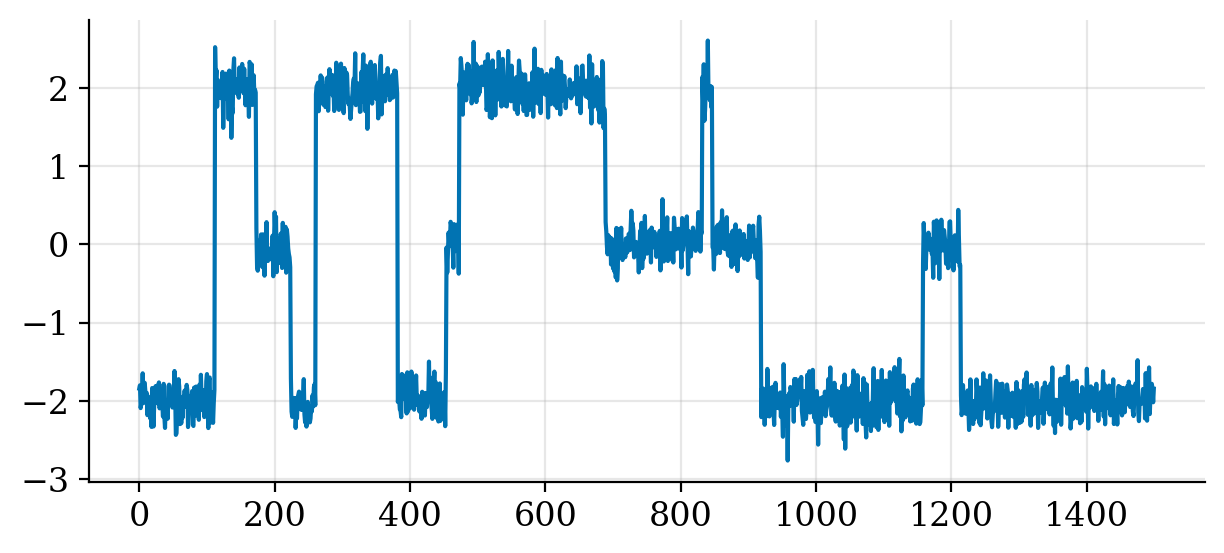

In [8]:
plt.plot(obs)
plt.grid(alpha=0.3)

---

## Finite hidden state-space model (v.0)

The transition probabilities are known.

We consider the following HMM assumption
$$
\begin{aligned}
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta_{s_t} \mid m_0, s_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t},\,\sigma^2)
\end{aligned}
$$

with $\pi_{i,j}$ known for all $i,j$.

Let $\psi_t \in \Psi_t = \{1, 2, \ldots, K\}^t$
be an auxiliary variable denoting the history of regimes visited.

The posterior mass function for $\psi_t$ is

$$
\begin{aligned}
    p(\psi_t \mid y_{1:t})
    &= \sum_{\psi_{t-1}\in\Psi_{t-1}} p(\psi_t, \psi_{t-1} \mid y_{1:t})\\
    &= \sum_{\psi_{t-1}\in\Psi_{t-1}} p(\psi_t, \psi_{t-1} \mid y_{1:t-1}, y_t)\\
    &\propto \sum_{\psi_{t-1}\in\Psi_{t-1}} p(\psi_t, \psi_{t-1} \mid y_{1:t-1})\,p(y_t \mid \psi_t, \psi_{t-1}, y_{1:t-1})\\
    &= p(y_t \mid \psi_t, y_{1:t-1}) \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\psi_{t-1} \mid y_{1:t-1})\,p(\psi_t \mid \psi_{t-1})\\
\end{aligned}
$$

Here, $\psi_t = \psi_{t-1} \cup \{s_t\}$ and $\psi_{t-1} = \{s_1, \ldots, s_{t-1}\}$

The posterior predictive takes the form
$$
\begin{aligned}
    p(y_t \mid \psi_t, y_{1:t-1})
    &=\int p(y_t, \theta \mid  \psi_t, y_{1:t-1}) \d\theta\\
    &=\int p(\theta \mid \psi_t, y_{1:t-1})\,p(y_t \mid \theta)\d\theta
\end{aligned}
$$

The possible history of regimes to keep track of looks as follows
```python
[[1], [2], [3]]
-->
[[1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]]
-->
[[1,1,1], [1,1,2], [1,1,3], [1,2,1], [1,2,2], [1,2,3], [1,3,1], [1,3,2], ...]
```

In [9]:
@chex.dataclass
class ParticleState:
    means: jax.Array
    variances: jax.Array
    regime: jax.Array
    log_weight: jax.Array
    timestep: jax.Array

    @staticmethod
    def init(key, mean, cov, n_particles, n_regimes, n_steps):
        key_mean, key_regimes = jax.random.split(key)

        means = jax.random.normal(key_mean, (n_regimes, 1))
        means = einops.repeat(means, "k m -> s k m", s=n_particles)
        # means = einops.repeat(mean, "m -> s k m", s=n_particles, k=n_regimes)
        variances = einops.repeat(cov, "i -> s k i", s=n_particles, k=n_regimes)
        # regimes = jax.random.choice(key_regimes, n_regimes, (n_particles, n_steps)) # uniform sample over configs
        regimes = jnp.zeros((n_particles, n_steps)).astype(int)
        log_weights = jnp.full(n_particles, -jnp.log(n_particles))
        timestep = jnp.zeros(n_particles)
        
        return ParticleState(
            means=means, 
            variances=variances,
            regime=regimes,
            log_weight=log_weights,
            timestep=timestep,
        )


@chex.dataclass
class Cfg:
    var: float

In [10]:
def multinomial_resampling(key, log_weights, n_particles):
    indices = jax.random.categorical(key, log_weights, shape=(n_particles,))
    return indices


def flatten_particles(tree):
    """
    Given any pytree with leaf shapes (particles options ...),
    we stack the leaf to be (particle options) ...
    """
    einops_expr = "particles options ... -> (particles options) ..."
    res = jax.tree.map(lambda x: einops.rearrange(x, einops_expr), tree)
    return res

## Sample from transition

## Evaluate — do not sampe

In [11]:
@partial(jax.vmap, in_axes=(None, 0, None, None))
def update(y, regime, bel, cfg):
    """
    Update over all regimes
    """
    mean = bel.means[regime]
    var = bel.variances[regime]
    yhat = mean
    
    err = y - yhat
    kt = var / (var + cfg.var)
    mean_update = mean + kt * err
    var_update = kt * cfg.var # (1 - kt) * var

    pred_sttdev = jnp.sqrt(var + cfg.var)
    log_pp = jax.scipy.stats.norm.logpdf(y, yhat, pred_sttdev).squeeze()

    bel = bel.replace(
        means=bel.means.at[regime].set(mean_update),
        variances=bel.variances.at[regime].set(var_update),
        regime=bel.regime.at[bel.timestep.astype(int)].set(regime),
        timestep=bel.timestep + 1,
    )
    return bel, (log_pp, yhat)


@partial(jax.vmap, in_axes=(None, 0, None))
def vstep_update(y, bel, cfg):
    """
    Update all possible beliefs
    """
    log_p_transition = log_transition_matrix[bel.regime[bel.timestep.astype(int)]]
    regimes = jnp.arange(n_regimes)
    bel_update, (log_pp, mean_pred) = update(y, regimes, bel, cfg)
    # bel_update = bel_update.replace(regime=regimes) # regimes are updated inside

    log_weight = bel.log_weight + log_pp + log_p_transition
    return bel_update, (log_weight, mean_pred)

def _resample(key, log_weights, bel):
    """
    Resample particles if the effective sample size (ESS)
    is below some threshold
    """
    # Resample indices according to log-likelihood
    # indices = jax.random.categorical(key, log_weights, shape=(n_particles,))
    indices = multinomial_resampling(key, log_weights, n_particles)
    # indices = stratified_resampling(key, log_weights, n_particles)
    
    # Update new belief
    bel = jax.tree.map(lambda x: x[indices], bel)
    
    # Reset particles
    bel = bel.replace(
        log_weight=jnp.full(n_particles, -jnp.log(n_particles))
    )
    return bel


def step_optimal(bel, xs, cfg):
    y, key = xs
    bel_update, (log_weights, mean_pred_all) = vstep_update(y, bel, cfg)
    bel_update, log_weights, mean_pred_all = flatten_particles((bel_update, log_weights, mean_pred_all))

    # Prediced mean
    mean_pred_all = mean_pred_all.ravel()
    weights_pred = jnp.exp(bel.log_weight - jax.nn.logsumexp(bel.log_weight))
    predicted_mean = (weights_pred[:, None] * mean_pred_all).sum(axis=0)

    # Update weights, compute the effective sample size
    log_weights_norm = log_weights - jax.nn.logsumexp(log_weights)
    ess = 1 / jnp.sum(jnp.exp(log_weights_norm) ** 2)

    weights = jnp.exp(log_weights_norm)
    mean_position = jnp.einsum("s...,s->...", bel_update.means, weights)
    std_position = jnp.sqrt(jnp.einsum("s...,s->...", bel_update.variances, weights))

    bel_update = _resample(key, log_weights, bel_update)
    

    return bel_update, (bel_update.log_weight, mean_position, std_position, ess)

## Run

In [12]:
n_particles = 1
mean_init = jnp.array([0.0])
var_init = jnp.array([0.05]) ** 2

key_init, key_eval = jax.random.split(key_run)
bel_init = ParticleState.init(key_init, mean_init, var_init, n_particles, n_regimes, n_steps)
jax.tree.map(jnp.shape, bel_init)

ParticleState(means=(1, 3, 1), variances=(1, 3, 1), regime=(1, 1500), log_weight=(1,), timestep=(1,))

In [13]:
bel_init.means

Array([[[-0.75979435],
        [-0.9137966 ],
        [ 0.8703681 ]]], dtype=float32)

In [14]:
cfg = Cfg(var=0.2 ** 2)
keys = jax.random.split(key_eval, n_steps)
Xs = (obs, keys)
_step = partial(step_optimal, cfg=cfg)
bel_final, (hist_ll, hist_mean, hist_std, hist_ess) = jax.lax.scan(_step, bel_init, Xs)
hist_mean = hist_mean.squeeze()
hist_std = hist_std.squeeze()

In [15]:
timesteps = jnp.arange(n_steps)

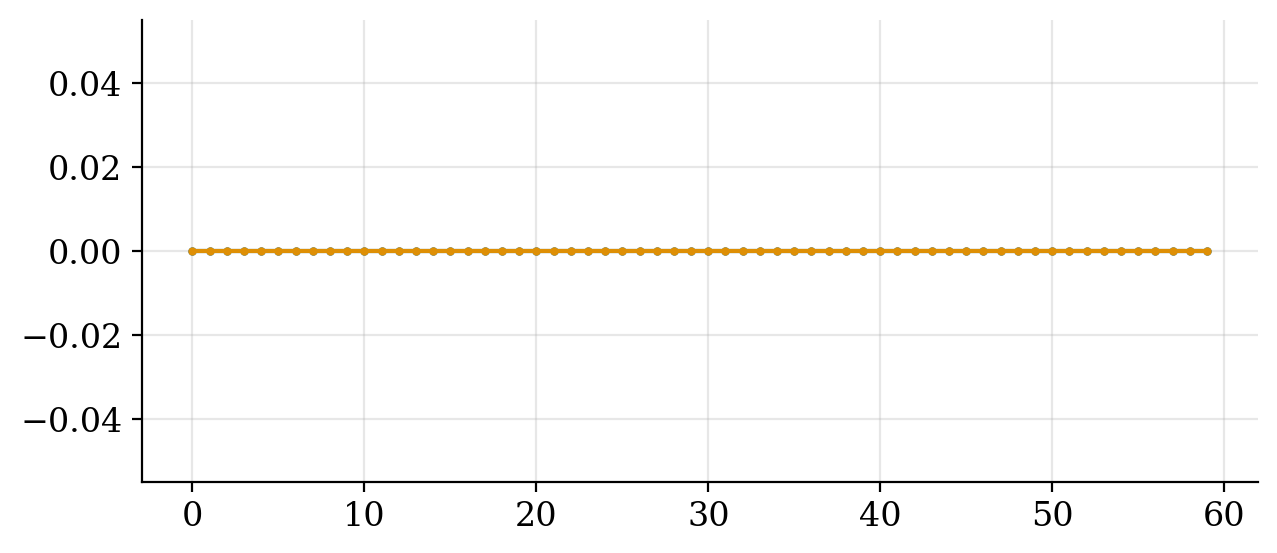

In [16]:
tslice = slice(0, 60)
plt.step(timesteps[tslice], bel_final.regime[0][tslice], marker="o", where="post", markersize=2)
plt.step(timesteps[tslice], states[tslice], where="post", marker="o", markersize=2)
plt.grid(alpha=0.3)

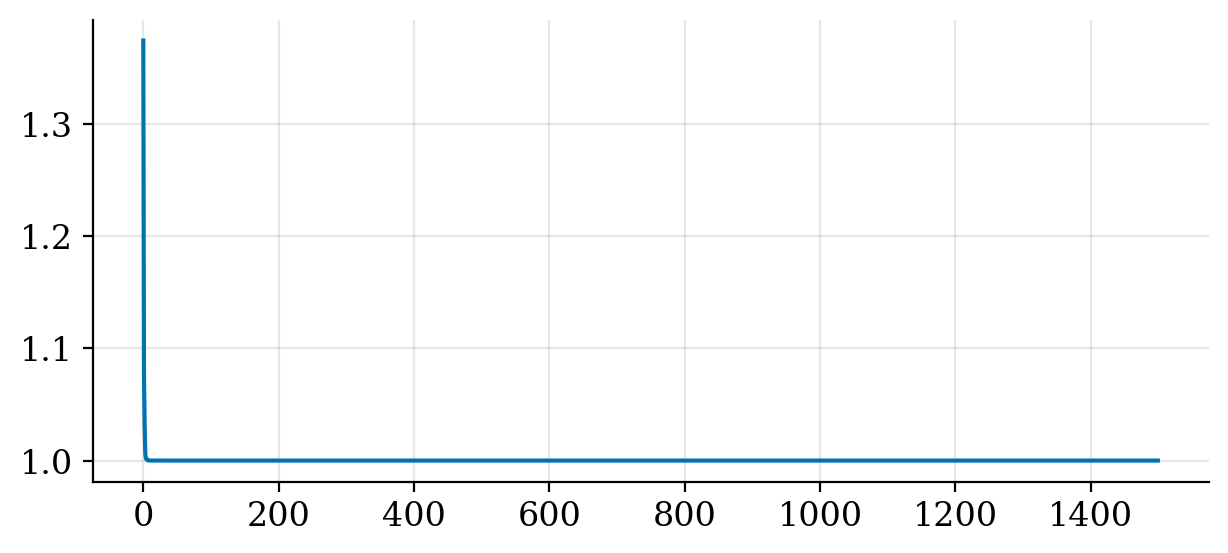

In [17]:
plt.plot(hist_ess)
plt.grid(alpha=0.3)

In [18]:
jax.tree.map(jnp.shape, bel_final)

ParticleState(means=(1, 3, 1), variances=(1, 3, 1), regime=(1, 1500), log_weight=(1,), timestep=(1,))

In [19]:
weights = jnp.exp(hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True))

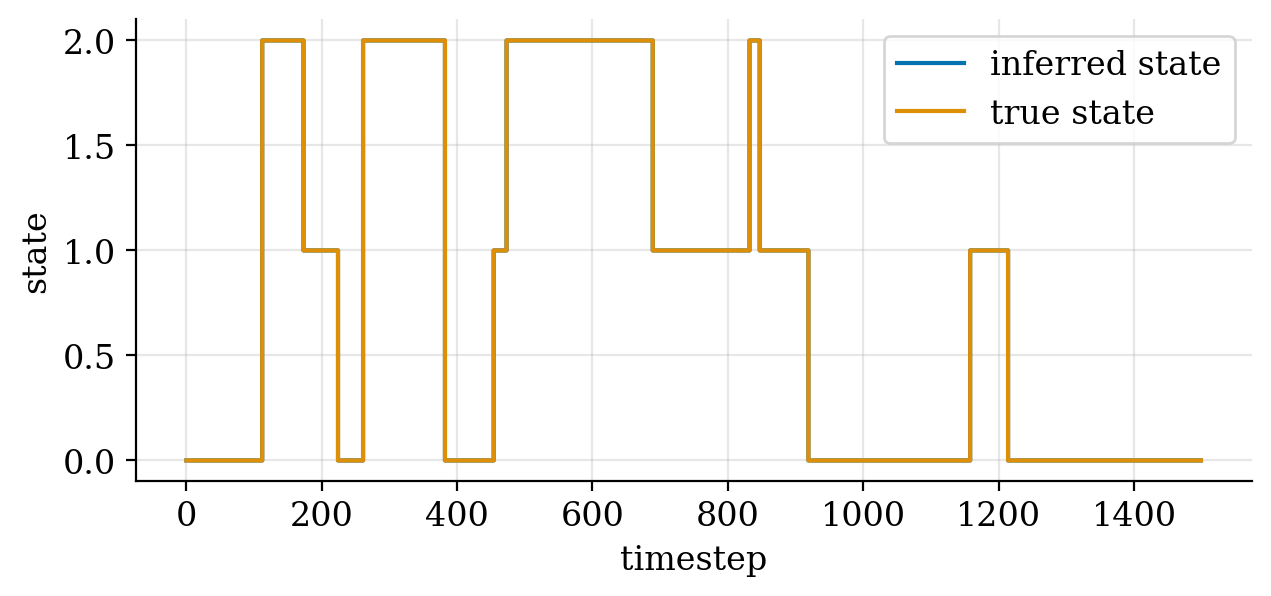

In [20]:
plt.step(timesteps, (bel_final.regime.T * weights).sum(axis=1), label="inferred state", where="post")
plt.step(timesteps, states, label="true state", where="post")
plt.ylabel("state")
plt.xlabel("timestep")
plt.legend()
plt.grid(alpha=0.3)

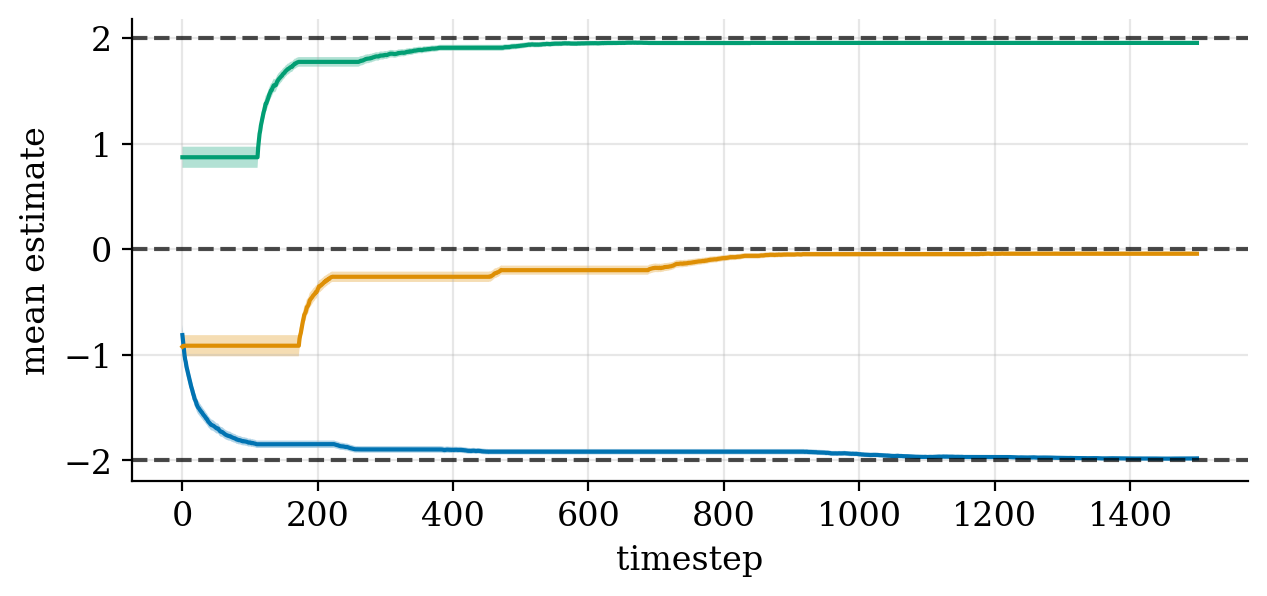

In [21]:
colors = sns.color_palette()
for i, mean in enumerate(means):
    mean_i = hist_mean[:, i]
    std_i = hist_std[:, i]
    lbound, ubound = mean_i - 2 * std_i, mean_i + 2 * std_i
    plt.plot(timesteps, mean_i, c=colors[i])
    plt.fill_between(timesteps, lbound, ubound, alpha=0.3)
    plt.axhline(y=mean, c="black", linestyle="--", alpha=0.7)
plt.ylabel("mean estimate")
plt.xlabel("timestep")
plt.grid(alpha=0.3)

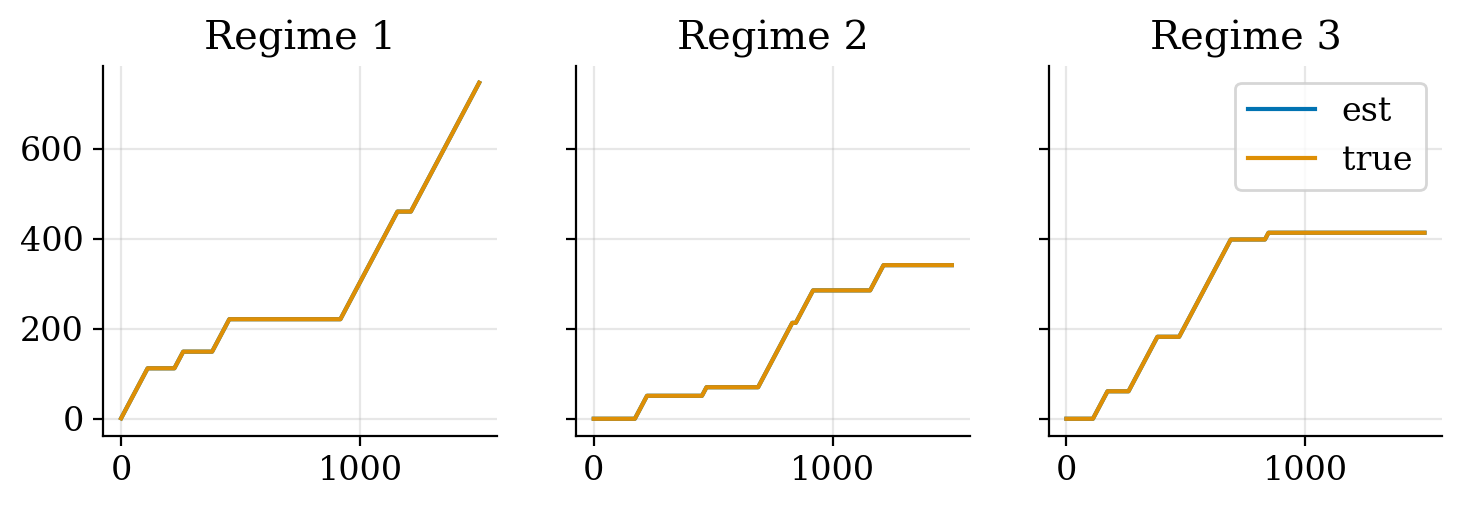

In [22]:
regimes_est_count = jax.nn.one_hot(bel_final.regime, 3).cumsum(axis=1).squeeze()
regimes_true_count = jax.nn.one_hot(states, 3).cumsum(axis=0)

ix = 0
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(7.2 * 1.2, 3.0 * 0.8))
for ix, ax in enumerate(axs):
    ax.plot(regimes_est_count[:, ix], label="est")
    ax.plot(regimes_true_count[:, ix], label="true")
    ax.set_title(f"Regime {ix+1}")
    ax.grid(alpha=0.3)
plt.legend()

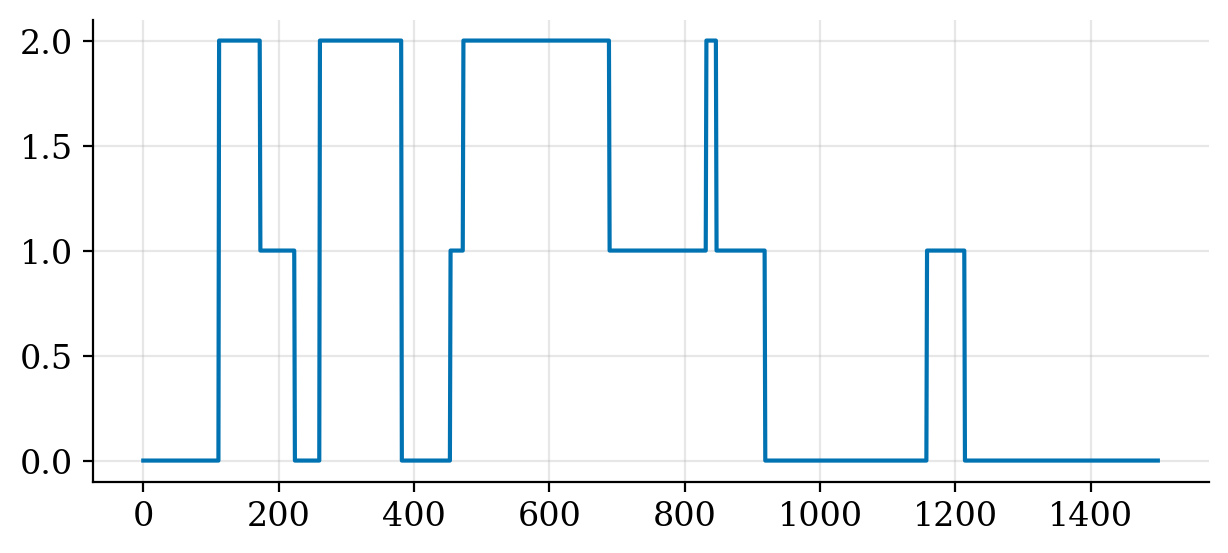

In [23]:
plt.plot(states)
plt.grid(alpha=0.3)

## Sample from transition

In [24]:
def update(y, regime, bel, cfg):
    """
    Update over all regimes
    """
    mean = bel.means[regime]
    var = bel.variances[regime]
    yhat = mean
    
    err = y - yhat
    kt = var / (var + cfg.var)
    mean_update = mean + kt * err
    var_update = kt * cfg.var # (1 - kt) * var

    pred_sttdev = jnp.sqrt(var + cfg.var)
    log_pp = jax.scipy.stats.norm.logpdf(y, yhat, pred_sttdev).squeeze()

    bel = bel.replace(
        means=bel.means.at[regime].set(mean_update),
        variances=bel.variances.at[regime].set(var_update),
        regime=bel.regime.at[bel.timestep.astype(int)].set(regime),
        timestep=bel.timestep + 1,
    )
    return bel, (log_pp, yhat)



@partial(jax.vmap, in_axes=(0, None, 0, None))
def step_update(key, y, bel, cfg):
    """
    Update all possible beliefs
    """
    log_p_transition = log_transition_matrix[bel.regime[bel.timestep.astype(int)]]
    regime_next = jax.random.categorical(key, log_p_transition)
    bel_update, (log_pp, mean_pred) = update(y, regime_next, bel, cfg)

    log_weight = bel.log_weight + log_pp
    return bel_update, (log_weight, mean_pred)


def _resample(key, log_weights, bel):
    """
    Resample particles if the effective sample size (ESS)
    is below some threshold
    """
    # Resample indices according to log-likelihood
    # indices = jax.random.categorical(key, log_weights, shape=(n_particles,))
    indices = multinomial_resampling(key, log_weights, n_particles)
    # indices = stratified_resampling(key, log_weights, n_particles)
    
    # Update new belief
    bel = jax.tree.map(lambda x: x[indices], bel)
    
    # Reset particles
    bel = bel.replace(
        log_weight=jnp.full(n_particles, -jnp.log(n_particles))
    )
    return bel


def _continue(key, log_weights, bel):
    bel = bel.replace(
        log_weight=log_weights
    )
    return bel


def step_optimal(bel, xs, cfg):
    y, key = xs
    
    key_propagate, key_resample = jax.random.split(key)
    keys = jax.random.split(key_propagate, n_particles)
    
    bel_update, (log_weights, mean_pred_all) = step_update(keys, y, bel, cfg)

    # Prediced mean
    mean_pred_all = mean_pred_all.ravel()
    weights_pred = jnp.exp(log_weights - jax.nn.logsumexp(log_weights))
    predicted_mean = (weights_pred[:, None] * mean_pred_all).sum(axis=0)

    # Update weights, compute the effective sample size
    ess = 1 / jnp.sum(weights_pred ** 2)

    ### Resample step ###
    bel_update = jax.lax.cond(
        ess < n_particles * 0.2,
        _resample,
        _continue,
        key_resample, log_weights, bel_update
    )

    weights = jnp.exp(bel.log_weight - jax.nn.logsumexp(bel.log_weight))
    mean_position = jnp.einsum("s...,s->...", bel_update.means, weights)
    

    return bel_update, (bel_update.log_weight, mean_position, ess)

---

## Finite hidden state-space model (v.1)

Transition probabilities are not known.

A sticky-HMM assumption.

We consider the following HMM assumption
$$
\begin{aligned}
    \boldsymbol\pi_\ell &\sim {\rm Dir}(\alpha + \kappa\,\boldsymbol e_\ell) \quad\, \forall \ell\in\{1,\ldots, K\}\\
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta_{s_t} \mid m_0, s_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t},\,\sigma^2)
\end{aligned}
$$

In [343]:
alpha = 0.5
kappa = 1
regime = 1

ohe_regime = jax.nn.one_hot(regime, num_regimes)

proba_regimes = alpha + kappa * ohe_regime
jax.random.dirichlet(key_pi, proba_regimes).round(2)

NameError: name 'num_regimes' is not defined

Let $\psi_t \in \{1, 2, \ldots, K\}^t$. We seek

$$
\begin{aligned}
    p(\psi_t, \boldsymbol P \mid y_{1:t})
    &= \sum_{\psi_t \in \Psi_t}
\end{aligned}
$$

Let $\psi_t \in \{1, 2, \ldots, K\}^t$. We seek

$$
\begin{aligned}
    p(\psi_t \mid y_{1:t})
    &= \sum_{\psi_{t-1}\in\Psi_{t-1}} p(\psi_t, \psi_{t-1} \mid y_{1:t})\\
    &= \sum_{\psi_{t-1} \in \Psi_{t-1}}\int p(\vP, \psi_t, \psi_{t-1} \mid y_{1:t}) d\vP\\
    &= \int \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\vP, \psi_t, \psi_{t-1} \mid y_{1:t-1}, y_t) d\vP\\
    &\propto \int \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\vP, \psi_t, \psi_{t-1} \mid y_{1:t-1}) p(y_t \mid \vP, \psi_t, \psi_{t-1}, y_{1:t}) d\vP \\
    &= \int \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\vP, \psi_t, \psi_{t-1} \mid y_{1:t-1}) p(y_t \mid \psi_t, y_{1:t-1}) d\vP \\
    &= p(y_t \mid \psi_t, y_{1:t-1})
    \sum_{\psi_{t-1} \in \Psi_{t-1}} \int
    p(\vP, \psi_t, \psi_{t-1} \mid y_{1:t-1}) d\vP \\
    &=
    p(y_t \mid \psi_t, y_{1:t-1})
    \sum_{\psi_{t-1} \in \Psi_{t-1}}\int 
    p(\vP \mid y_{1:t-1})\,
    p(\psi_{t-1} \mid \vP, y_{1:t-1})\,
    p(\psi_t \mid \psi_{t-1}, \vP, y_{1:t-1})
    d\vP \\
    &= p(y_t \mid \psi_t, y_{1:t-1})
    \sum_{\psi_{t-1} \in \Psi_{t-1}}
    \int
    p(\vP \mid y_{1:t-1})\,
    p(\psi_{t-1} \mid y_{1:t-1})\,
    p(\psi_t \mid \psi_{t-1}, \vP)
    d\vP \\
    &= p(y_t \mid \psi_t, y_{1:t-1})
    \sum_{\psi_{t-1} \in \Psi_{t-1}}
    p(\psi_{t-1} \mid y_{1:t-1})\,
    \int
    p(\vP \mid y_{1:t-1})\,
    p(\psi_t \mid \psi_{t-1}, \vP)
    d\vP \\
    &= p(y_t \mid \psi_t, y_{1:t-1})
    \sum_{\psi_{t-1} \in \Psi_{t-1}}
    p(\psi_{t-1} \mid y_{1:t-1})\,
    \int
    p(\boldsymbol \pi_{s_{t-1}} \mid y_{1:t-1})\,
    \pi_{s_{t-1}, s_t}
    d\boldsymbol \pi_{s_{t-1}}
\end{aligned}
$$

Furthermore, estimation for $\vP$, conditioned on $\psi_t$ and $\psi_{t-1}$ becomes

$$
\begin{aligned}
    p(\vP \mid \psi_t, \psi_{t-1},  y_{1:t})
    &= p(\vP \mid \psi_t, \psi_{t-1},  y_{1:t-1}, y_t)\\
    &\propto p(\vP \mid \psi_t, \psi_{t-1},  y_{1:t-1})\,p(y_t \mid \psi_t, \psi_{t-1}, \vP, y_{1:t-1})\\
    &\propto \pi_{s_t, s_{t-1}}\,p(y_t \mid \psi_t, y_{1:t-1})
\end{aligned}
$$

$$
\begin{aligned}
    p(\boldsymbol\pi, s_t \mid y_{1:t})
    &= p(s_t \mid y_{1:t})\,p(\vP \mid s_t,\,y_{1:t})\\
    &= p(s_t \mid y_{1:t})\,p(\boldsymbol\pi_{s_t} \mid y_{1:t})
\end{aligned}
$$

$$
\begin{aligned}
    p(\boldsymbol\pi, s_t \mid y_{1:t})
    &= \sum_{s_{t-1}=1}^K p(\boldsymbol\pi, s_t, s_{t-1} \mid y_{1:t})\\
    &= \sum_{s_{t-1}=1}^K p(\boldsymbol\pi, s_t, s_{t-1} \mid y_{1:t-1}, y_t)\\
    &= \sum_{s_{t-1}=1}^K p(s_{t-1} \mid y_{1:t-1})\,p(s_t \mid s_{t-1}, y_{1:t})
\end{aligned}
$$

Let $\psi_t = \{s_1,  \ldots, s_t\}$.
Conditioned on state $s_{t+1}$,
the posterior predictive takes the form

$$
    p(y_{t+1} \mid s_{t+1},\,y_{1:t}) = {\cal N}(y_{t+1} \mid m_{\psi_t},\,s^2_{\psi_t})
$$

$\{s_k \mid s_k = s_{t+1} \,\forall\, k=1\ldots, t\}$

---

## The finite-state model (v.2)

$$
\begin{aligned}
    \boldsymbol\beta &\sim {\rm SB}(\gamma)\\
    \boldsymbol\pi_\ell &\sim {\rm DP}(\boldsymbol\beta)\\
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta \mid m_0, s_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t}, \sigma^2)
\end{aligned}
$$

In [90]:
key

Array([  0, 314], dtype=uint32)

In [26]:
key_beta, key_pi = jax.random.split(key_sample)

In [27]:
gamma = 1.0
beta = jax.random.dirichlet(key_beta, gamma / num_regimes * jnp.ones(num_regimes))
beta

Array([0.4314185 , 0.01197072, 0.55661076], dtype=float32)

In [56]:
alpha = 0.5
kappa = 1

proba_regimes = alpha * beta + jnp.eye(num_regimes)
jax.random.dirichlet(key_pi, proba_regimes).round(2)

Array([[0.85999995, 0.        , 0.14      ],
       [0.        , 0.95      , 0.05      ],
       [0.55      , 0.        , 0.45      ]], dtype=float32)

In [58]:
proba_regimes

Array([[1.2157092 , 0.00598536, 0.27830538],
       [0.21570925, 1.0059854 , 0.27830538],
       [0.21570925, 0.00598536, 1.2783054 ]], dtype=float32)

In [45]:
jax.vmap(jax.random.dirichlet, in_axes=(None, 0))(key_pi, proba_regimes).sum(axis=1)

Array([1., 1., 1.], dtype=float32)

---

## The infinite-state model

$$
\begin{aligned}
    \boldsymbol\beta &\sim {\rm SB}(\gamma)\\
    \boldsymbol\pi_\ell &\sim {\rm DP}(\boldsymbol\beta)\\
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta \mid m_0, s_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t}, \sigma^2)
\end{aligned}
$$